In [ ]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

df = pd.read_excel("fr_countvectorizer.xlsx")
y = df["label"]

def parse_dict(x):
    d = {}
    for pair in str(x).split(","):
        if ":" in pair:
            k, v = pair.split(":")
            d[k.strip()] = float(v.strip())
    return d

count_dicts = df["countvectorizer"].apply(parse_dict)

vec = DictVectorizer(sparse=True)
X = vec.fit_transform(count_dicts)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

svm_model = CalibratedClassifierCV(
    estimator=LinearSVC(random_state=42),
    cv=3
)

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

nb_model = MultinomialNB()

base_models = [
    ("rf", rf_model),
    ("svm", svm_model),
    ("nb", nb_model)
]

meta_model = LogisticRegression(max_iter=2000)

stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    stack_method="predict_proba",
    n_jobs=-1
)

stack_model.fit(X_train, y_train)

y_pred = stack_model.predict(X_test)

print("\n=== EVALUATION REPORT ===")
print(classification_report(y_test, y_pred))



=== EVALUATION REPORT ===
              precision    recall  f1-score   support

          CG       0.89      0.90      0.89      4044
          OR       0.89      0.88      0.89      4043

    accuracy                           0.89      8087
   macro avg       0.89      0.89      0.89      8087
weighted avg       0.89      0.89      0.89      8087



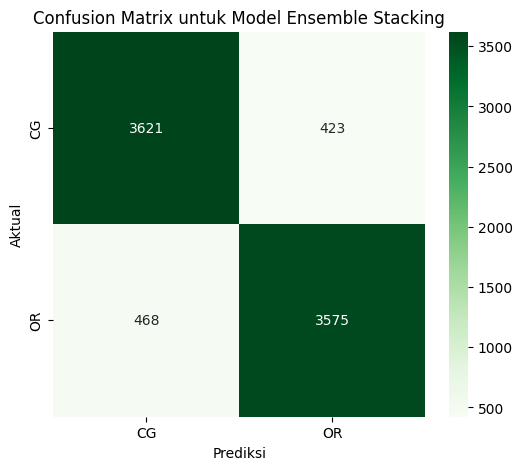

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
labels = ["CG", "OR"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix untuk Model Ensemble Stacking")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()